In [1]:
!pip install pydicom
#!pip install glob
#!pip install pylab
!pip install datatime
import pandas as pd
import numpy as np
import random
import csv
import os
import pydicom
import glob, pylab
import cv2

from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
import keras.backend as K
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator



from matplotlib import pyplot as plt
import matplotlib.patches as patches

     |████████████████████████████████| 35.3MB 88kB/s 
ERROR: Could not find a version that satisfies the requirement datatime (from versions: none)
ERROR: No matching distribution found for datatime


Using TensorFlow backend.


In [0]:
import keras
import tensorflow as tf
from keras import regularizers
from keras.datasets import mnist
from keras.models import Sequential
from keras.models import Model, Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.applications.densenet import DenseNet121
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix,roc_auc_score



In [3]:
#Mounting drive
from google.colab import drive
drive.mount('./content/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./content/


In [0]:
#Defining project path
project_path = "./content/My Drive/"

In [0]:
#Unzippiong data file
from zipfile import ZipFile
with ZipFile('./content/My Drive/rsna-pneumonia-detection-challenge.zip', 'r') as z:
  z.extractall()

# CLASSIFICATION MODEL


In [0]:
#Obtataining labels of all patients and their Patient Id's
# empty dictionary
pneumonia_class = {}
# load table
with open('stage_2_train_labels.csv', mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rowsn
    index = -1
    for rows in reader:
        # retrieve information
        filename = rows[0]
        #location = rows[1:5]
        pneumonia = rows[5]
        #add label to dictionary
        if filename not in pneumonia_class:
          
          pneumonia_class[filename] = {
                                     'label' : pneumonia
                                    
                                      }
        

In [0]:
#Conveting class information to Series
label = pd.Series(pneumonia_class)


- Train and Validaiton split


In [34]:
# load and shuffle unique filenames from train images (One patient has only one X-ray image)
folder = 'stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames (90:10 split)
n_valid_samples = 2704
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 23980
n valid samples 2704


- DATA GENERTOR

- IMAGE AUGMENTATIONS

In [0]:
#DEFINING DIFFERENT AUGMENTATIONS TO APPLY ON THE IMAGES DURING TRAINING

import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

# dictionary of the transformations functions we defined earlier
available_transformations = {
    #'rotate': random_rotation,
    #'noise': random_noise,
    'horizontal_flip': horizontal_flip
}

- CUSTOM GENERATOR FOR CLASSIFICATION

In [0]:
#Custome Generator Function to supply batches of training and validation data
class generator(keras.utils.Sequence):

    def __init__(self, folder,filenames, batch_size = 32, image_size=256, shuffle=True, aug=False, predict=False ):
        self.folder = folder
        self.filenames = filenames
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.aug = aug
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filenames):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filenames)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        #Normalize
        img = img/255
        #Target Variable
        pid = filenames.split('.')[0]
        cls = label[pid]['label']
        # Apply augmentation to Pnuemonia patients as there is class missbalance in data
        if self.aug and random.random()>0.5:
          # random num of transformations to apply
          num_transformations_to_apply = random.randint(1, len(available_transformations))
          num_transformations = 0
          while num_transformations <= num_transformations_to_apply:
            # choose a random transformation to apply for a single image
            key = random.choice(list(available_transformations))
            img = available_transformations[key](img)
            image = np.broadcast_to(img[...,np.newaxis],(self.image_size,self.image_size,3))
            num_transformations += 1
            return image,cls # returning augmented image and corresponding class
        else:
          img = np.broadcast_to(img[...,np.newaxis],(self.image_size,self.image_size,3))
          return img,cls # returning class '0' without augmentation
          
    def __loadpredict__(self, filenames):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filenames)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        img = img/255
        # add trailing channel dimension
        img = np.broadcast_to(img[...,np.newaxis],(self.image_size,self.image_size,3))
        PatientId = filenames.split('.')[0]
        return img,PatientId
    
            
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            items = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs_predict, PatientIds = zip(*items)
            imgs_predict = np.array(imgs_predict)
            PatientIds = np.array(PatientIds)
            return  imgs_predict, PatientIds

        # train mode: return images and class
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs_train, cls_train = zip(*items)
            # create numpy batch
            imgs_train = np.array(imgs_train)
            cls_train = np.array(cls_train)
            return imgs_train, cls_train
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

        

- MODEL FOR CLASSIFICATION

Chexnet Model (DenseNet121) is choosen as its weights are pretrained for identifying chest x-ray images.  The last two layers of Chexnet Model are removed and replaced with custom Dense layers for binary classification of Pnuemonia patients

In [37]:

# Constant parameters 
image_size =  256
input_shape = (image_size, image_size, 3)
num_classes = 1

#Initialize the model

inputs = Input(shape=input_shape)

chexNet = DenseNet121(
          include_top=True
        , input_tensor=inputs
        , weights="/content/content/My Drive/ChexNet_weight.h5"
        , classes=14
    )
 
chexNet = Model(
          inputs=inputs
        , outputs=chexNet.layers[-2].output
        , name="ChexNet"
    )
 # Weights downloaded from https://github.com/erniechiew/kaggle_rsna_pneumonia_dancingbears/tree/master/classification 

model = Sequential()

model.add(chexNet)

model.add(Dropout(0.6, name="drop_0"))
#model.add(Dense(512, activation = 'relu', name = "dense_0", kernel_regularizer = regularizers.l2(0.01)))
model.add(Dense(512, activation = 'relu', name = 'dense_1', kernel_regularizer = regularizers.l2(0.01)))
model.add(Dense(256, activation = None, name = 'dense_2', kernel_regularizer = regularizers.l2(0.01)))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.6, name="drop_2"))
model.add(Dense(1, activation="sigmoid", name="out"))



model.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ChexNet (Model)              (None, 1024)              7037504   
_________________________________________________________________
drop_0 (Dropout)             (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
drop_2 (Dropout)             (None, 256)               0         
____

- Train and Validation Batches

Batch size and image_size hyper parameters are selected according to constraints of the colab which gives 12GB RAM for the session.  Tried for different image and batch sizes to fit within the limitation of RAM and minimizing validation loss.

Different number of nodes for the custom Dense layers tried and the above model was found to give better performance in terms of accuracy.  

In [0]:

# create train and validation generators
folder = 'stage_2_train_images'
train_gen = generator(folder, train_filenames,  batch_size=16, image_size=256, shuffle=True, aug = True, predict = False)
valid_gen = generator(folder, valid_filenames,  batch_size=16, image_size=256, shuffle=False, aug = False, predict = False)

- Defining Callbacks

Checkpoint, ReduceLROnPlateu and EarlyStopping are defined as callbacks.  TensorBoard callback also tried to implement.  As it was making the training even slower it was removed.  

Callbacks_list = [checkpoint, ReduceLROnPlateu and EarlyStopping]

**Checkpoint** was defined to save the best model according to minimimum val loss, **ReduceLROnPlateau** was implemented to reduce learning rate if validaiton loss doesnot decrease after 3 epochs.  **EarlyStopping** is implemented when  validation loss doesnot decrease after 7 epochs (i.e, even after implementing ReduceLROnPlateau callback twice

In [0]:
checkpoint = ModelCheckpoint(
         "classifier_768_ClassMultiaug_adam1.h5"
        , monitor="val_loss"
        , verbose=1
        , save_best_only=True
        , mode="min"
        , save_weights_only = False
    )

reduceLROnPlat = ReduceLROnPlateau(
          monitor="val_loss"
        , factor=0.1
        , patience=3
        , verbose=1
        , mode="auto"
        , min_delta=0.0001
        , cooldown=5
        , min_lr=0.0001
    )
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=7)

callbacks_list= [checkpoint, reduceLROnPlat, early_stopping]


- Different Opitimizers and loss functions are checked for the binary classification.  Adam was found to do better than SGD with less val loss. Binary Crossentroy was used as loss function.

- Learning rate was tuned to different initial values.  lr = 0.005 was found to be best initial value that will bring the loss down early.

- Each epoch was taking around 15min to complete, with a batch size of 16 and appox. 90/10 split

- Compiling Model

In [0]:
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.losses import binary_crossentropy
#opt = keras.optimizers.SGD(lr = 0.005, decay = 0.001)
opt = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])



- Epochs run by augmenting, only the Pneumonia positive dataset as there are less in number compared to Pnuemonia negative patients.  The Epochs were initially done for 15, but when model is found to overfit it was stopped at 9th epoch.

- Next, the model was run for only 4 epochs to have better weights

- Training network

- Random horizontal flip augmentation over predefined set of augmentations done over all datapoints. 



In [0]:
# optimizer = adam, Augmentation flip applied random number of times on whole of training set
history_classaug_adam = model.fit_generator(train_gen, validation_data=valid_gen, callbacks =  callbacks_list, epochs=15, workers=4, use_multiprocessing=False, verbose=1)



Epoch 1/15
1507/1507 [==============================] - 1138s 755ms/step - loss: 1.2658 - acc: 0.8259 - val_loss: 0.3847 - val_acc: 0.8469

Epoch 00001: val_loss improved from inf to 0.38466, saving model to classifier_768_ClassMultiaug_adam.h5
Epoch 2/15
1507/1507 [==============================] - 1074s 713ms/step - loss: 0.3481 - acc: 0.8546 - val_loss: 0.3571 - val_acc: 0.8449

Epoch 00002: val_loss improved from 0.38466 to 0.35713, saving model to classifier_768_ClassMultiaug_adam.h5
Epoch 3/15
1507/1507 [==============================] - 1066s 707ms/step - loss: 0.3127 - acc: 0.8683 - val_loss: 0.3575 - val_acc: 0.8500

Epoch 00003: val_loss did not improve from 0.35713
Epoch 4/15
1507/1507 [==============================] - 1070s 710ms/step - loss: 0.2843 - acc: 0.8789 - val_loss: 0.3715 - val_acc: 0.8438

Epoch 00004: val_loss did not improve from 0.35713
Epoch 5/15
1507/1507 [==============================] - 1063s 706ms/step - loss: 0.2603 - acc: 0.8903 - val_loss: 0.3981 -

In [0]:
history_classaug_adam = model.fit_generator(train_gen, validation_data=valid_gen, callbacks =  callbacks_list, epochs = 4, workers=4, use_multiprocessing=False, verbose=1)



Epoch 1/4
1498/1498 [==============================] - 1153s 769ms/step - loss: 1.2166 - acc: 0.8280 - val_loss: 0.3705 - val_acc: 0.8499

Epoch 00001: val_loss improved from inf to 0.37052, saving model to classifier_768_ClassMultiaug_adam.h5
Epoch 2/4
1498/1498 [==============================] - 1069s 714ms/step - loss: 0.3494 - acc: 0.8524 - val_loss: 0.3427 - val_acc: 0.8547

Epoch 00002: val_loss improved from 0.37052 to 0.34275, saving model to classifier_768_ClassMultiaug_adam.h5
Epoch 3/4
1498/1498 [==============================] - 1070s 714ms/step - loss: 0.3120 - acc: 0.8641 - val_loss: 0.3498 - val_acc: 0.8532

Epoch 00003: val_loss did not improve from 0.34275
Epoch 4/4
1498/1498 [==============================] - 1073s 716ms/step - loss: 0.2857 - acc: 0.8770 - val_loss: 0.3885 - val_acc: 0.8450

Epoch 00004: val_loss did not improve from 0.34275


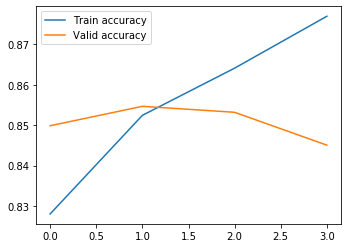

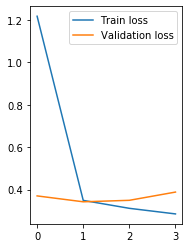

In [0]:
#VALIDATION AND TRAINING EPOCH PLOTS
plt.figure(figsize=(12,4))


plt.subplot(122)
plt.plot(history_classaug_adam.epoch, history_classaug_adam.history["acc"], label="Train accuracy")
plt.plot(history_classaug_adam.epoch, history_classaug_adam.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.show()

plt.subplot(121)
plt.plot(history_classaug_adam.epoch, history_classaug_adam.history["loss"], label="Train loss")
plt.plot(history_classaug_adam.epoch, history_classaug_adam.history["val_loss"], label="Validation loss")
plt.legend()
plt.show()

In [0]:
#simple horizontal flip
history_768 = model.fit_generator(train_gen, validation_data=valid_gen, callbacks =  callbacks_list, epochs=4, workers=4, use_multiprocessing=False, verbose=1)

Epoch 1/4
1498/1498 [==============================] - 1320s 881ms/step - loss: 0.8731 - acc: 0.8273 - val_loss: 0.3539 - val_acc: 0.8624

Epoch 00001: val_loss improved from inf to 0.35385, saving model to classifier_768_ClassMultiaug_adam1.h5
Epoch 2/4
1498/1498 [==============================] - 1306s 872ms/step - loss: 0.3615 - acc: 0.8469 - val_loss: 0.3285 - val_acc: 0.8646

Epoch 00002: val_loss improved from 0.35385 to 0.32852, saving model to classifier_768_ClassMultiaug_adam1.h5
Epoch 3/4
1498/1498 [==============================] - 1318s 880ms/step - loss: 0.3358 - acc: 0.8549 - val_loss: 0.3240 - val_acc: 0.8646

Epoch 00003: val_loss improved from 0.32852 to 0.32401, saving model to classifier_768_ClassMultiaug_adam1.h5
Epoch 4/4
1498/1498 [==============================] - 1317s 879ms/step - loss: 0.3207 - acc: 0.8623 - val_loss: 0.3246 - val_acc: 0.8584

Epoch 00004: val_loss did not improve from 0.32401


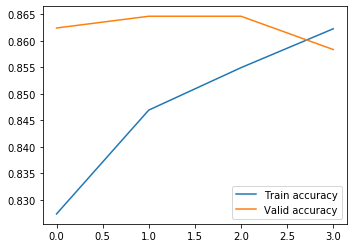

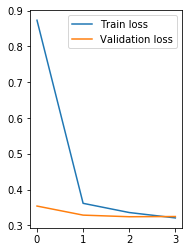

In [0]:
#VALIDATION AND TRAINING EPOCH PLOTS
plt.figure(figsize=(12,4))


plt.subplot(122)
plt.plot(history_768.epoch, history_768.history["acc"], label="Train accuracy")
plt.plot(history_768.epoch, history_768.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.show()

plt.subplot(121)
plt.plot(history_768.epoch, history_768.history["loss"], label="Train loss")
plt.plot(history_768.epoch, history_768.history["val_loss"], label="Validation loss")
plt.legend()
plt.show()

- The Classification model has final validation accuracy of around 86% which is better than random

- A minimum validation loss was achieved

- Validation Step

In [0]:
model.load_weights('/content/content/My Drive/CHEXNET_CLASSIFICATION_FINAL.h5')

In [0]:
# Obtaining classes of Patients
valid_proba = model.predict_generator(valid_gen)





In [0]:
threshold = 0.5
valid_classes = (valid_proba >= threshold).astype('int')

valid_class = pd.DataFrame()
valid_class['PatientId'] = valid_filenames
valid_class['Class'] = valid_classes

valid_class.head()

,PatientId,Class
0,ace01ccc-dbc9-4d12-b6c4-6ca3dcafe11e.dcm,0
1,6648e4d4-8073-454a-83a6-f3e7fe775a0b.dcm,0
2,71846fc9-ef2c-41ee-bb57-b513217438e1.dcm,0
3,ebb542b8-7a87-4d0a-81d0-ecbc529a9e8d.dcm,0
4,8d4c6a5c-34c7-43ae-9f95-7c013eff7eec.dcm,0


In [0]:
# Generating array of y_true for model validation
valid_true = []
for filename in valid_filenames:
  filename = filename.split('.')[0]
  y_true = pneumonia_class[filename]['label']
  valid_true.append(y_true)

valid_true = np.array(valid_true, dtype = 'int64')


- Accuracy, Precision, Recall and Confusion Matrix

In [0]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(valid_true, valid_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(valid_true, valid_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(valid_true, valid_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(valid_true, valid_classes)
print('F1 score: %f' % f1)
# ROC AUC
auc = roc_auc_score(valid_true, valid_classes)
print('ROC AUC : %f' % auc)
# Confusion Matrix
matrix = confusion_matrix(valid_true, valid_classes)
print(matrix)


Accuracy: 0.866864
Precision: 0.753086
Recall: 0.603960
F1 score: 0.670330
ROC AUC : 0.773382
[[1978  120]
 [ 240  366]]


- The ChexNet Classification Model will be used to predict the classes of Patients in the Test data.  

- As only Pnuemonia patients have Bounding boxes, the patients classified as having Pnuemonia, are passed to the Boudning Box Prediction Model

- PNEUMONIA PREDICTOR FOR TEST DATASET

In [40]:
# load and shuffle filenames
folder_test = '/content/stage_2_test_images'
test_filenames = os.listdir(folder_test)
print('n test samples:', len(test_filenames))

n test samples: 3000


- Test data Class prediction 

In [41]:
#Predicting Class of  Patients in the test data
test_gen = generator(folder_test, test_filenames, batch_size=16, image_size=256, shuffle=False, aug = False, predict=True)

test_proba = model.predict_generator(test_gen)

threshold = 0.5
test_classes = (test_proba >= threshold).astype('int')

test_class = pd.DataFrame()
test_class['PatientId'] = test_filenames
test_class['Class'] = test_classes

test_class.head()


,PatientId,Class
0,1b095207-1f70-4e5a-87e5-23c8666f266b.dcm,0
1,250d9e6f-afbb-4188-b61c-50e669ded9d2.dcm,0
2,c01261ad-12bf-4ac1-8621-96881a939fd6.dcm,0
3,044702b8-5ad7-493c-ac3b-1fe5292a62b2.dcm,0
4,04ba9dc3-9cf1-41f5-9e4d-939bd69c97f6.dcm,0


In [42]:
#Extracting only Pnuemonia positive patients 
test_class_1 = test_class[test_class['Class'] == 1]

filenames_for_testing = pd.Series(test_class_1['PatientId'])
Target_1 = pd.Series(test_class_1['Class'])

test_class_1

,PatientId,Class
11,2b635aad-66e7-49da-808e-14f59dc98fe0.dcm,1
13,2a3fc253-6d7f-48ea-ab20-377272cd1bda.dcm,1
21,272be76e-0270-4c10-819d-c32ec14ade4b.dcm,1
25,2aa6506f-a7a0-4057-bc65-e56a27370698.dcm,1
27,003fbda2-ba55-4714-a03a-83f15bec19e4.dcm,1
...,...,...
2954,c1bea7c6-14cb-483c-b2ee-e958901f0667.dcm,1
2973,01594bc6-16eb-4214-b2b2-4cf2154dbab9.dcm,1
2974,0e133eeb-8b1f-491f-b9f2-9c2dcb393e82.dcm,1
2979,011d6083-abaa-4b28-8a53-36aa0cddb3b5.dcm,1


- 565 patients are sent for Bounding box prediction

In [0]:
#Prediction of test data to csv
test_class.to_csv(r'Classification_Prediction.csv', index = None, header=True) 

# BOUNDING BOX MODEL




- Bounding Box Model input will be only Pnuemonia patients and their bounding boxes from the entire dataset.



- DICTIONARY OF ONLY PNEUMONIA PATIENTS AND BOUNDING BOX LOCATIONS
AS MODEL INPUT

In [0]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('/content/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [0]:
filenames_bb = list(pneumonia_locations.keys())

- Training and validation split

In [8]:
#DIVIDING INTO TRAINING AND VALIDATION DATA
n_valid_samples = 600
train_filenames_bb = filenames_bb[n_valid_samples:]
valid_filenames_bb = filenames_bb[:n_valid_samples]
print('n train samples for bounding box prediction', len(train_filenames_bb))
print('n valid samples for bounding box prediciton', len(valid_filenames_bb))
#n_train_samples = len(filenames_bb) - n_valid_samples

n train samples for bounding box prediction 5412
n valid samples for bounding box prediciton 600


- GENERATOR FUNCTOIN FOR BOUNDNG BOX MODEL

In [0]:
class generatorbb(keras.utils.Sequence):

  def __init__(self, folder,filenames, pnuemonia_locations = None, batch_size = 32, image_size=256, shuffle=True, aug=False, predict=False ):
        self.folder = folder
        self.filenames = filenames
        self.pnuemonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.aug = aug
        self.predict = predict
        self.on_epoch_end()
        
  def __load__(self, filename):
        # load dicom file as numpy array
        filename = '%s.dcm' % filename
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in pneumonia_locations:
          # loop through pneumonia
          for location in pneumonia_locations[filename]:
            # add 1's at the location of the pneumonia
            x, y, w, h = location
            msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.aug and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
  def __loadpredict__(self, filename):
        # load dicom file as numpy array
        #filename = '%s.dcm' % filename
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        #removing extension
        filename = filename.split('.')[0]
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
  def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            #filenames_predict = np.asarray(filenames)
            return imgs,filenames

        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
  def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
  def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
           return int(np.ceil(len(self.filenames) / self.batch_size))

- NETWORK FOR BOUDNING BOX PREDICTION.  

- CNN SEGMENTATION MODEL IS DEFINED, BY GRADJUALLY DOWNSAMPLING OF IMAGE TO 16 X 16,  AND FINALLY UPSAMPLING TO THE ORIGINAL INPUT SIZE.
- CONNECTED COMPONENTS ARE USED IN FINALIZING THE BOUNDING BOXES

In [0]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
            # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model_bb = keras.Model(inputs=inputs, outputs=outputs)
    return model_bb

    

In [11]:
# create network and compiler
model_bb = create_network(input_size = 256, channels=32)
model_bb.summary()














Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________

- CREATING TRAIN AND VALIDATION BATCHES

In [0]:
# Predict Flag is set as true only for Test data.  Shuffle is True in training phase
# create train and validation generators
folder_train = '/content/stage_2_train_images'
train_gen = generatorbb(folder_train, train_filenames_bb, pneumonia_locations, 16, image_size=256, shuffle=True, aug=True, predict = False)
valid_gen = generatorbb(folder_train, valid_filenames_bb, pneumonia_locations, 16,  image_size=256, shuffle=False, predict=False)

- LOSS FUNCTION


 The loss function of the model, comprises of  only the boudning box loss parameter, as the prediction is already made in the first model

In [0]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score


# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))


- COMPILING MODEL

In [20]:
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.losses import binary_crossentropy
#opt = keras.optimizers.SGD(lr = 0.005, decay = 0.001)
opt = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001)
#model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
#opt = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001)
model_bb.compile(optimizer= opt,
                 loss = [iou_loss],
              metrics = [mean_iou,'accuracy'])

- 'Adam' is found to converge faster than 'SGD'

- CALLBACKS

In [0]:
checkpoint = ModelCheckpoint(
        "classifier_bb.h5"
        , monitor="val_loss"
        , verbose=1
        , save_best_only=True
        , mode="min"
        , save_weights_only=False
    )

reduceLROnPlat = ReduceLROnPlateau(
          monitor="val_loss"
        , factor=0.1
        , patience=3
        , verbose=1
        , mode="auto"
        , min_delta=0.0001
        , cooldown=5
        , min_lr=0.0001
    )
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=8)




In [0]:
callbacks_list_bb = [reduceLROnPlat, early_stopping]

- TensorBoard Call Backs was also tried using NGROK.  Its visualization was not on colab, hence it wasnot effective and it was also slowing down the time taken for each epochs.  

- MODEL TRAINING

Augmenting images for training in Bouning box prediction, was increasing the IOU of the training data, but failing miserably in prediction for validation data.  Hence it was dropped.  Some of the initial interations are shown above

In [0]:
#With default LR value in Adam opitmizer
history = model_bb.fit_generator(train_gen, validation_data=valid_gen, callbacks = callbacks_list_bb, epochs=20, workers=4, use_multiprocessing=True)

Epoch 1/20
339/339 [==============================] - 795s 2s/step - loss: 0.6693 - mean_iou: 0.3014 - val_loss: 0.6478 - val_mean_iou: 0.3191

Epoch 00001: val_loss improved from inf to 0.64779, saving model to classifier_bb.h5
Epoch 2/20
339/339 [==============================] - 709s 2s/step - loss: 0.6437 - mean_iou: 0.3238 - val_loss: 0.6473 - val_mean_iou: 0.3224

Epoch 00002: val_loss improved from 0.64779 to 0.64725, saving model to classifier_bb.h5
Epoch 3/20
339/339 [==============================] - 721s 2s/step - loss: 0.6281 - mean_iou: 0.3372 - val_loss: 0.6371 - val_mean_iou: 0.3396

Epoch 00003: val_loss improved from 0.64725 to 0.63707, saving model to classifier_bb.h5
Epoch 4/20
339/339 [==============================] - 733s 2s/step - loss: 0.6247 - mean_iou: 0.3380 - val_loss: 0.6520 - val_mean_iou: 0.3307

Epoch 00004: val_loss did not improve from 0.63707
Epoch 5/20
339/339 [==============================] - 734s 2s/step - loss: 0.6181 - mean_iou: 0.3424 - val_los

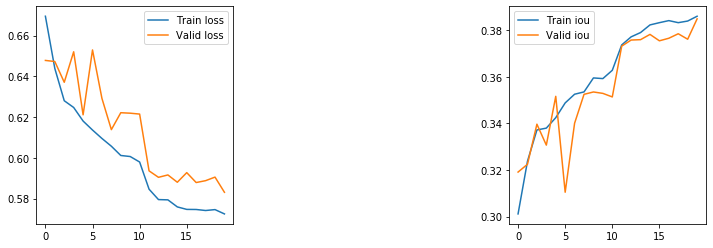

In [0]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()

plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

In [24]:
# With tuned initial LR value of Adam opitmizer and along with decay
history_bb1 = model_bb.fit_generator(train_gen, validation_data=valid_gen, callbacks = callbacks_list_bb, epochs=15, workers=4, use_multiprocessing=True)

Epoch 1/15
339/339 [==============================] - 615s 2s/step - loss: 0.6260 - mean_iou: 0.3446 - acc: 0.8684 - val_loss: 0.7123 - val_mean_iou: 0.2707 - val_acc: 0.8636
Epoch 2/15
339/339 [==============================] - 589s 2s/step - loss: 0.5782 - mean_iou: 0.3833 - acc: 0.8937 - val_loss: 0.5856 - val_mean_iou: 0.3834 - val_acc: 0.8895
Epoch 3/15
339/339 [==============================] - 586s 2s/step - loss: 0.5584 - mean_iou: 0.4009 - acc: 0.9005 - val_loss: 0.5918 - val_mean_iou: 0.3776 - val_acc: 0.8952
Epoch 4/15
339/339 [==============================] - 584s 2s/step - loss: 0.5428 - mean_iou: 0.4144 - acc: 0.9051 - val_loss: 0.5921 - val_mean_iou: 0.3778 - val_acc: 0.9014
Epoch 5/15
339/339 [==============================] - 591s 2s/step - loss: 0.5358 - mean_iou: 0.4210 - acc: 0.9073 - val_loss: 0.5477 - val_mean_iou: 0.4163 - val_acc: 0.8910
Epoch 6/15
339/339 [==============================] - 590s 2s/step - loss: 0.5278 - mean_iou: 0.4309 - acc: 0.9088 - val_loss

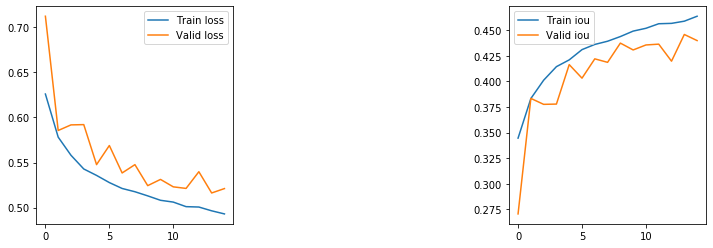

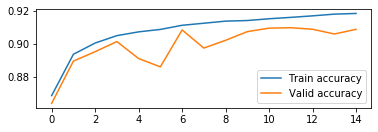

In [31]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history_bb1.epoch, history_bb1.history["loss"], label="Train loss")
plt.plot(history_bb1.epoch, history_bb1.history["val_loss"], label="Valid loss")
plt.legend()

plt.subplot(133)
plt.plot(history_bb1.epoch, history_bb1.history["mean_iou"], label="Train iou")
plt.plot(history_bb1.epoch, history_bb1.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

plt.subplot(211)
plt.plot(history_bb1.epoch, history_bb1.history["acc"], label="Train accuracy")
plt.plot(history_bb1.epoch, history_bb1.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.show()

- PLOTS OF TRAIN AND VALIDATION LOSS AND THEIR THEIR METRIC

 

 The size of the image when reduced to 128 x 128, the IOU was beolor 0.2 and the memory available in colab coulnot handle higher sizes.

 The split of 90/10 approx. was found to go well with the required validation IOU than normal 80/20 split

 Batch size of 16 was doing better interms of model performance and memory requirements during compute.  Found better than 32 in terms of model performance and computation ease.

- visualisation of ground truth and prediction bounding boxes

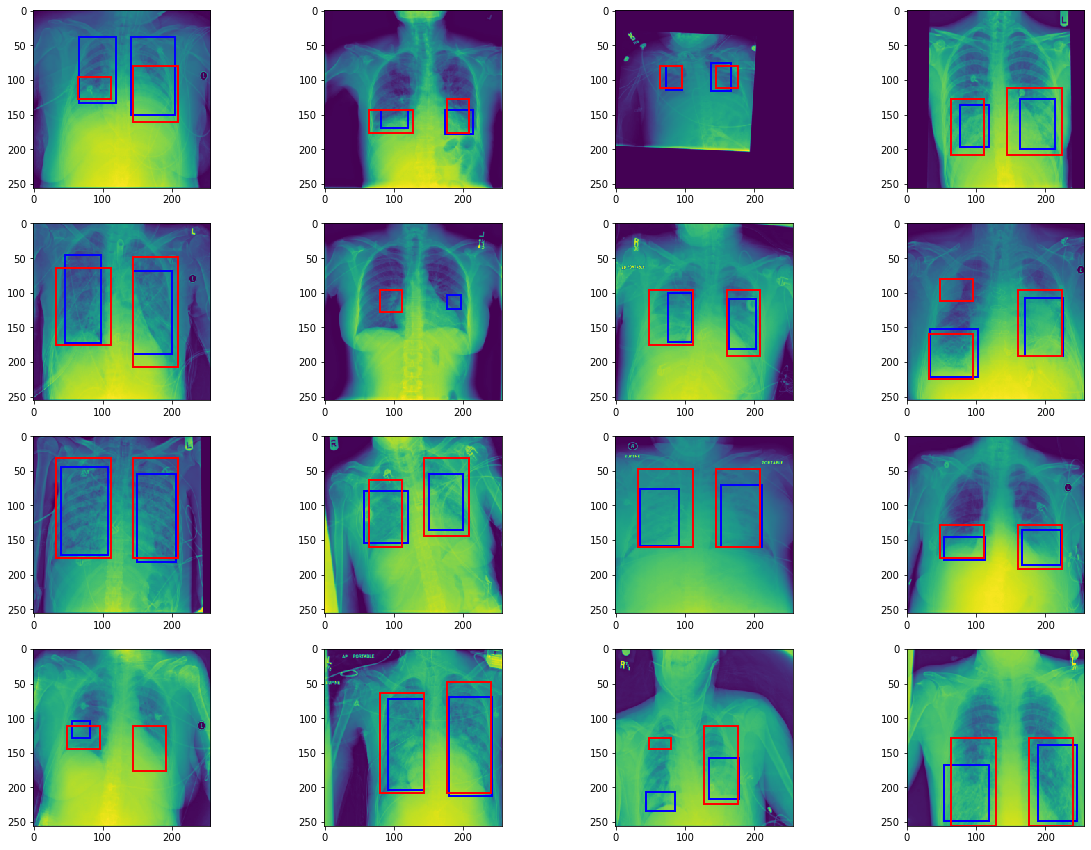

In [0]:
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model_bb.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4,4, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

BOUDNING BOX PREDICTOR FOR PNEUMONIA PATIENTS


In [0]:
#model_bb.load_weights('/content/content/My Drive/classifier_bb_256.h5')

- Pnuemonia patients from the the test dataset classified as positive by classification model is fed to the bounding box prediction model

- PREDICTING BOUNDING BOXES

In [44]:
# load and shuffle filenames
folder_test = '/content/stage_2_test_images'
test_filenames = filenames_for_testing
print('TEST SAMPLES FOR BOUDNING BOX PREDICTION FROM CLASSIFICTION MODEL:', len(filenames_for_testing))



TEST SAMPLES FOR BOUDNING BOX PREDICTION FROM CLASSIFICTION MODEL: 545


- CREATING TEST BATCHES AND PREDICTION 

In [0]:
# create test generator with predict flag set to True
test_gen = generatorbb(folder_test, test_filenames, None, batch_size=1, image_size=256, shuffle=False, predict=True)

In [0]:
# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model_bb.predict(imgs)
    # loop through batch
    for pred,filename in zip(preds,filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            #retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            width = x2 - x
            height = y2-y
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf)  + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) +  ' '
        # add filename and predictionString to dictionary
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) > len(test_filenames):
        break

In [47]:
# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict, orient = 'index')
sub.index.names = ['PatientId']
sub.columns = ['PredictionString']
sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 545 entries, 2b635aad-66e7-49da-808e-14f59dc98fe0.dcm to 2a655317-ec64-47b8-b3ca-6b347b7aad2f.dcm
Data columns (total 1 columns):
PredictionString    545 non-null object
dtypes: object(1)
memory usage: 8.5+ KB


In [0]:
#Preparation of submission format
sub.reset_index(inplace = True)
submission = pd.merge(left = test_class, right = sub, on = 'PatientId', how = 'left')
pd.DataFrame.drop(submission, 'Class', inplace = True, axis = 1)

#Removing file extension
submission['PatientId'] = submission['PatientId'].str[:-4]


In [49]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 2 columns):
PatientId           3000 non-null object
PredictionString    545 non-null object
dtypes: object(2)
memory usage: 70.3+ KB


In [50]:
submission.head(20)

,PatientId,PredictionString
0,1b095207-1f70-4e5a-87e5-23c8666f266b,NaN
1,250d9e6f-afbb-4188-b61c-50e669ded9d2,NaN
2,c01261ad-12bf-4ac1-8621-96881a939fd6,NaN
3,044702b8-5ad7-493c-ac3b-1fe5292a62b2,NaN
4,04ba9dc3-9cf1-41f5-9e4d-939bd69c97f6,NaN
5,2e74f5a7-5959-4b0b-87ea-18b0fa308e7e,NaN
6,24a968f6-bd26-4ef1-90b7-ca75df777e56,NaN
7,231abfb6-8c40-43dd-923a-ee88d540ef50,NaN
8,0e6ca7b6-3d33-4d09-8c1e-6c1d0ffaa844,NaN
9,30a3b04b-6164-40ac-9361-b0beb0ffe663,NaN


In [0]:
submission.to_csv(r'kaggle170220.csv', index = None, header = True)

# Deployment of Model using Flask

- The weights obtained in the classification model with LOSS function as binary_crossentropy and Metric is Accuracy is used in the Flask for deplopyment.

- The second detection model weights with custom loss of IOU_LOSS and Metric of "mean_iou" was tried but the module wasnot recognizing custom defined functions.  Hence, weights are obtained for the same loss and accuracy settngs of classification model for Flask implementation of detection model.

In [0]:
# create network and compiler
model_bb_flask = create_network(input_size = 256, channels=32)
model_bb_flask.summary()














Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________

In [0]:
opt = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001)
model_bb_flask.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
checkpoint = ModelCheckpoint(
        "classifier_bb_flask.h5"
        , monitor="val_loss"
        , verbose=1
        , save_best_only=True
        , mode="min"
        , save_weights_only=False
    )

reduceLROnPlat = ReduceLROnPlateau(
          monitor="val_loss"
        , factor=0.1
        , patience=3
        , verbose=1
        , mode="auto"
        , min_delta=0.0001
        , cooldown=5
        , min_lr=0.0001
    )
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=8)

In [0]:
callbacks_list_bb_flask = [reduceLROnPlat, checkpoint, early_stopping]

In [0]:
history_flask = model_bb_flask.fit_generator(train_gen, validation_data=valid_gen, callbacks = callbacks_list_bb_flask, epochs=10, workers=4, use_multiprocessing=True)



Epoch 1/10
338/339 [============================>.] - ETA: 1s - loss: 0.2450 - acc: 0.8942

339/339 [==============================] - 560s 2s/step - loss: 0.2448 - acc: 0.8943 - val_loss: 0.2765 - val_acc: 0.8839

Epoch 00001: val_loss improved from inf to 0.27653, saving model to classifier_bb_flask.h5
Epoch 2/10
339/339 [==============================] - 512s 2s/step - loss: 0.2000 - acc: 0.9121 - val_loss: 0.2331 - val_acc: 0.8983

Epoch 00002: val_loss improved from 0.27653 to 0.23311, saving model to classifier_bb_flask.h5
Epoch 3/10
339/339 [==============================] - 523s 2s/step - loss: 0.1908 - acc: 0.9159 - val_loss: 0.2638 - val_acc: 0.8883

Epoch 00003: val_loss did not improve from 0.23311
Epoch 4/10
339/339 [==============================] - 526s 2s/step - loss: 0.1838 - acc: 0.9185 - val_loss: 0.2256 - val_acc: 0.9013

Epoch 00004: val_loss improved from 0.23311 to 0.22560, saving model to classifier_bb_flask.h5
Epoch 5/10
339/339 [=============================

OSError: ignored